In [1]:
# !Importing Modules

import sklearn
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

from statistics import stdev
from scipy.stats import pearsonr
from livelossplot import PlotLossesKeras

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings('ignore')

In [63]:
class predictions:
    # This class is used to predict the future values of the time series data
    
        def __init__(self , CHC):
                """Initializing the class with the CHC of the interest

                Args:
                        chc ([type:str]): CHC for which prediction is to be made
                """
                self.chc = CHC

        def malaria_data_processing(self, data_path):
                month_dict = {'JANUARY':1, 'FEBRUARY':2, 'MARCH':3, 'APRIL':4, 'MAY':5, 'JUNE':6, 'JULY':7, 'AUGUST':8, 'SEPTEMBER ':9, 'SEPTEMBER':9, 'OCTOBER':10, 'NOVEMBER':11, 'DECEMBER':12, 'DECEMBER ':12}

                data = pd.read_csv(data_path)

                year_list = list(np.unique(data['Year']))
                md = data[data['CHC'] == self.chc]
                return_data = []

                for i in year_list:
                        df = ((md[md['Year'] == i][['Month', 'malaria_total']]).groupby('Month').sum())['malaria_total']
                        df = df.reset_index(inplace=False)
                        list_data = list((df.sort_values('Month', key = lambda x : x.apply (lambda x : month_dict[x])))['malaria_total'])
                        return_data.append(list_data)
                        
                flat_list = [item for sublist in return_data for item in sublist]
                flat_list = pd.DataFrame(flat_list)
                return flat_list
        
        # Climate Data Preprocessing

        def import_climate_data(self, data_path):
                df = pd.read_csv(data_path, parse_dates=True)
                df['month'] = pd.to_datetime(df['weeks']).dt.month
                df['year'] = pd.to_datetime(df['weeks']).dt.year
                df = df.groupby(['year','month'],as_index=False).mean()
                df = df.drop(['year' , 'month'],axis=1)
                
                return df
        
        def import_data(self):
                """This will help in importing the data with a little bit of preprocessing using the pre_defined functions
                
                                * Rainfall Data: Rainfall CHC wise rainfall data for Odisha state. 
                                                * Spatial Resolution: 0.5 x 0.5
                                                * Temporal Resolution: Monthly average of daily data
                                                * Source: IMD Gridded Rainfall Data
                                                
                                * Temeprature Data: Temperature CHC wise temperature data for Odisha state.
                                                * Spatila Resolution: 0.5 x 0.5
                                                * Source: ERA5 Reanalysis data
                                                * Temporal Resolution: Daily data
                                                
                                        * Tmax Data: Maximum Temperature
                                                * Temporal Resolution: Monthly maximum of daily data
                                                
                                        *Tmin Data: Minimum Temperature
                                                * Temporal Resolution: Monthly minimum of daily data
                                
                                * Humidity Data: Humidity CHC wise humidity data for Odisha state.
                                                * Spatial Resolution: 0.5 x 0.5
                                                * Source: ERA5 Reanalysis data
                                                * Temporal Resolution: Monthly average of daily data
                                                
                                * Soil Moisture Data: Soil Moisture CHC wise soil moisture data for Odisha state.
                                                * Spatial Resolution: 0.5 x 0.5
                                                * Source: ERA5 Reanalysis data
                                                * Temporal Resolution: Monthly average of daily data
                                                
                                * Malaria Data: Malaria CHC wise malaria data for Odisha state.
                                                * Source: Odisha state health ministry
                                                * Temporal Resolution: Monthly average data
                Returns:
                        [DataFrame]: DataFrame of the data with target CHC
                """
                #* Importing raw Data for 40 years
                                
                malkangiri_data = self.malaria_data_processing(r'F:\IMACS\Data\M4_Data_Malkangiri.csv')
                koraput_data = self.malaria_data_processing(r'F:\IMACS\Data\M4_Data_Koraput.csv')
                
                rain = self.import_climate_data(r'F:\IMACS\Data\Climate_Sample_Data\Rain_40_years.csv')
                Tmax = self.import_climate_data(r'F:\IMACS\Data\Climate_Sample_Data\Tmax_40years.csv')
                Tmin = self.import_climate_data(r'F:\IMACS\Data\Climate_Sample_Data\Tmin_40years.csv')
                Humidity = self.import_climate_data(r'F:\IMACS\Data\Climate_Sample_Data\Humidity_40years.csv')
                Soil_moisture = self.import_climate_data(r'F:\IMACS\Data\Climate_Sample_Data\Soil_Moisture_40years.csv')
                
                df = []
                try: 
                        # an alternative would be to check the length of malkangiri_data and koraput_data and if length is greater than 1 then state the if condition
                        if self.chc in ['KORUKONDA' , 'PODIA']:                
                                df = pd.concat([rain[f'{self.chc}'] , Tmax[f'{self.chc}'] , Tmin[f'{self.chc}'] ,Humidity[f'{self.chc}'] , Soil_moisture[f'{self.chc}']],
                                                axis = 1, ignore_index=True)
                                df = df.tail(len(malkangiri_data))
                                df.reset_index(drop = True , inplace=True)
                                df = pd.concat([df , malkangiri_data[0]], axis = 1, ignore_index=True)
                                df.reset_index(drop = True , inplace=True)
                                df.columns = ['Rain' , 'Tmax' , 'Tmin', 'Humidity' , 'Soil_moisture', 'Malaria']
                        
                        if self.chc in ['BANDHUGAON' , 'LAXMIPUR']:                
                                df = pd.concat([rain[f'{self.chc}'] , Tmax[f'{self.chc}'] , Tmin[f'{self.chc}'] ,Humidity[f'{self.chc}'] , Soil_moisture[f'{self.chc}']],
                                                axis = 1, ignore_index=True)
                                df = df.tail(len(koraput_data))
                                df.reset_index(drop = True , inplace=True)
                                df = pd.concat([df , koraput_data[0]], axis = 1, ignore_index=True)
                                df.reset_index(drop = True , inplace=True)
                                df.columns = ['Rain' , 'Tmax' , 'Tmin', 'Humidity' , 'Soil_moisture', 'Malaria']
                except:
                        raise Exception('CHC not found')      
                return df
        
        def build_model(self , win_length, num_features):
            """Builds the LSTM model with the given parameters

            Args:
                win_length ([type: int]): Window length used for creating a sliding window
                
                num_features ([type: int]): Number of features used in training the model ( Here 5 features are used)
                                        * Rainfall
                                        * Tmax
                                        * Tmin
                                        * Humidity
                                        * Soil_moisture
            Returns:
                LSTM model
            """
            model =  tf.keras.Sequential()
            model.add(tf.keras.layers.LSTM(32, activation='elu', input_shape= (win_length, num_features)))
            model.add(tf.keras.layers.Dense(1))
            
            return model
    
        
        def model_training(self):
            """This function will do the following:
                * Split the data into training and testing data using train_test_split
                * Shift data to create lead times
                * Normalize the shifted data
                * Imports the model using build_model
                * compiles the model
                * Trains the model
                
                * For lead time 1 and 2, history of the model is saved
                * For each lead time, Correlation, MSE and R-squared are calculated and stored in a list
                * For each lead time, the predictions are made and stored in a pandas dataframe
                * Prediction are then passed through a variance correction function to remove the smoothness effect

            Args:
                df ([type: Pandas data frame]):  Data obtained as output of import_data function
                
            Returns:

            """
            
            ##---------------------- Empty buckets for skill scores----------------##
            
            # df = self.import_data()
            R_sqrd = []
            R_mse = []
            Corr = []

            for i in range(4):
                df = self.import_data()
                
                #! Create the Preictors and Predictand with traintestsplit
                                            
                df_input=df[['Rain' , 'Tmax' , 'Tmin', 'Humidity', 'Soil_moisture' , 'Malaria']]
                  
                X_train, X_test, y_train, y_test = train_test_split(df_input, df['Malaria'], test_size=0.20, random_state=123, shuffle = False)
                        
                    
                #! Shifting Data to create lag
                y_train = y_train.shift(-i)
                y_train = y_train.fillna(0)
                y_test = y_test.shift(-i)
                y_test = y_test.fillna(0)
                
                #! Scaling the data
                scaler = MinMaxScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)
                y_train = scaler.fit_transform(pd.DataFrame(y_train))
                y_test = scaler.fit_transform(pd.DataFrame(y_test))
                
                #! Creating the Timeseries Generator
                win_length=4
                batch_size=32
                num_features=6
                train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
                test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)
                
                #! Defining Model
                model =  self.build_model(win_length, num_features)

                # use of early stopping is optional since training time is short and #epochs is not a high value 
                #! Early Stopping
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=2,
                                                                mode='min')
                #! Model Compilation
                model.compile(loss=tf.losses.MeanSquaredError(),
                            optimizer=tf.optimizers.Adam(beta_1 = 0.5 , beta_2 = 0.9),
                            metrics=[tf.metrics.MeanAbsoluteError()])

                #! Model Fitting
                history = model.fit_generator(train_generator, epochs=50,
                                    validation_data=test_generator,
                                    # callbacks=[PlotLossesKeras()],
                                    shuffle=False , verbose = False)
                
                
                #! Saving the lead time 1 month model
                if i == 0:
                    training_mae = history.history['mean_absolute_error']
                    validation_mae = history.history['val_mean_absolute_error']
                
                #! Saving the lead time 2 month model
                if i == 1:
                    training_mae_2 = history.history['mean_absolute_error']
                    validation_mae_2 = history.history['val_mean_absolute_error']
                    
                if i == 0:
                    
                    predictions1 = model.predict(test_generator)
                    df_pred = pd.concat([pd.DataFrame(predictions1), pd.DataFrame(X_test[:,0].reshape(-1,1))],axis=1)
                    rev_trans1 = scaler.inverse_transform(df_pred)
                    df_final_1 = pd.DataFrame(rev_trans1)
                    df_final_1 = df_final_1.dropna()
                    dff = df_final_1
                    
                    sd_pred = stdev(dff[0])
                    sd_actual = stdev(dff[1])

                    mean_pred = np.mean(dff[0])
                    mean_actual = np.mean(dff[1])   

                    dff['var_corr'] = (dff[0] - mean_pred)*(sd_actual/sd_pred) + mean_actual
                    dff['var_corr'] = dff['var_corr'].apply(lambda x: np.abs(x))
                    
                    predictions=model.predict(test_generator)
                    df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][win_length:])],axis=1)
                    rev_trans=scaler.inverse_transform(df_pred)
                    df_final=df[predictions.shape[0]*-1:]
                    df_final['Malaria_pred']=rev_trans[:,0]
                
                if i == 1:
                    
                    predictions1=model.predict(test_generator)
                    df_pred=pd.concat([pd.DataFrame(predictions1), pd.DataFrame(X_test[:,0].reshape(-1,1))],axis=1)
                    rev_trans1=scaler.inverse_transform(df_pred)
                    df_final_1= pd.DataFrame(rev_trans1)
                    df_final_1 = df_final_1.dropna()
                    dff_1 = df_final_1
                    
                # #! Creating the Test predictions
                # predictions=model.predict(test_generator)
                # df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][win_length:])],axis=1)
                # rev_trans=scaler.inverse_transform(df_pred)
                # df_final=df[predictions.shape[0]*-1:]
                # df_final['Malaria_pred']=rev_trans[:,0]

                #! Calcukating the Corr and R-squared value for each tau
                corr,_ = pearsonr(df_final['Malaria'] , df_final['Malaria_pred'])
                Corr.append(corr)
                R_sqrd.append((corr**2))
                
                #! Calcukating the MSE value for each tau
                rms = mean_squared_error(df_final['Malaria'] , df_final['Malaria_pred'], squared=True)
                R_mse.append(rms)
                
            return dff, R_sqrd, R_mse, Corr, training_mae, validation_mae , training_mae_2, validation_mae_2, df_final, dff_1
    
        def show_training_results(self):
            
            dff, R_sqrd, R_mse, Corr, training_mae, validation_mae , training_mae_2, validation_mae_2, df_final, dff_1 = self.model_training()
            dist = self.chc
            fig, axs = plt.subplots(2,3, figsize=(23, 10), facecolor='w', edgecolor='k')
            fig.tight_layout(pad=4)

            #? Plotting the Epochs vs MAE for lead time 1 week
            axs[0][0].plot(training_mae, label='Training MAE')
            axs[0][0].plot(validation_mae, label='Validation MAE')
            axs[0][0].legend()
            axs[0][0].set_xlabel('Epoch' , size = 15)
            axs[0][0].set_ylabel('MAE', size = 15)
            axs[0][0].set_title(f'Epochs vs MAE for {dist} for Lead Time 1 month forecast', size = 15)
            
            #? Plotting the Epochs vs MAE for lead time 2 weeks
            axs[0][1].plot(training_mae_2, label='Training MAE')
            axs[0][1].plot(validation_mae_2, label='Validation MAE')
            axs[0][1].legend()
            axs[0][1].set_xlabel('Epoch', size = 15)
            axs[0][1].set_ylabel('MAE', size = 15)
            axs[0][1].set_title(f'Epochs vs MAE for {dist} for Lead Time 2 months forecast', size = 15)

            #? Plotting the Tau vs R-squared
            x = range(4)
            x_ticks = [1,2,3,4]
            axs[0][2].plot(range(4) , R_sqrd , '-o' , label = "R-squared")
            ax2 = axs[0][2].twinx()
            ax2.plot(range(4) , R_mse , '-o' , label = "MSE" , color = 'orange')
            axs[0][2].legend()
            ax2.legend()
            axs[0][2].set_xticks(x , x_ticks)
            axs[0][2].set_xlabel('Time Lead - Tau (in Months)', size = 15)
            axs[0][2].set_ylabel('R-squared', size = 15)
            ax2.set_ylabel('Mean Absolute Error', size = 15)
            axs[0][2].set_title(f'Lead Time vs Skill for {dist}', size = 15)

            #? Creating the Skill Score
            axs[1][0].text(0, 0.40, f'R-squared value for {dist} at lead Time 1 month is : {np.round(R_sqrd[0]*100 , 2)}' , size = 13)
            axs[1][0].text(0, 0.55, f'Corrleation value for {dist} at lead Time 1 month is : {np.round(Corr[0] , 2)}' , size = 13)
            axs[1][0].text(0, 0.7, f'MSE value for {dist} at lead Time 1 month is : {np.round((R_mse[0]) , 2)}' , size = 13)
            axs[1][0].axis('off')
            
            #? Creating the Skill Score
            axs[1][1].text(0, 0.40, f'R-squared value for {dist} at lead Time 2 month is : {np.round(R_sqrd[1]*100 , 2)}' , size = 13)
            axs[1][1].text(0, 0.55, f'Corrleation value for {dist} at lead Time 2 month is : {np.round(Corr[1] , 2)}' , size = 13)
            axs[1][1].text(0, 0.7, f'MSE value for {dist} at lead Time 2 month is : {np.round((R_mse[1]) , 2)}' , size = 13)
            axs[1][1].axis('off')
            
            #? Actual vs Predicted Plot
            axs[1][2].plot(dff[1] , label = "Actual")
            axs[1][2].plot(dff['var_corr'] , label = "var_corr_Predicted")
            axs[1][2].legend()
            axs[1][2].set_xlabel('Months (Test Period)', size = 15)
            axs[1][2].set_ylabel(f'Malaria Cases', size = 15)
            axs[1][2].set_title(f'Actual vs Predicted Malaria Cases for {dist} for Test Period for Lead Time 1 Month', size = 15)

            fig.show()
            # fig.savefig(f'{self.district}_{self.target}_{self.classifier}.png' , format = 'png' , bbox_inches = 'tight')
            

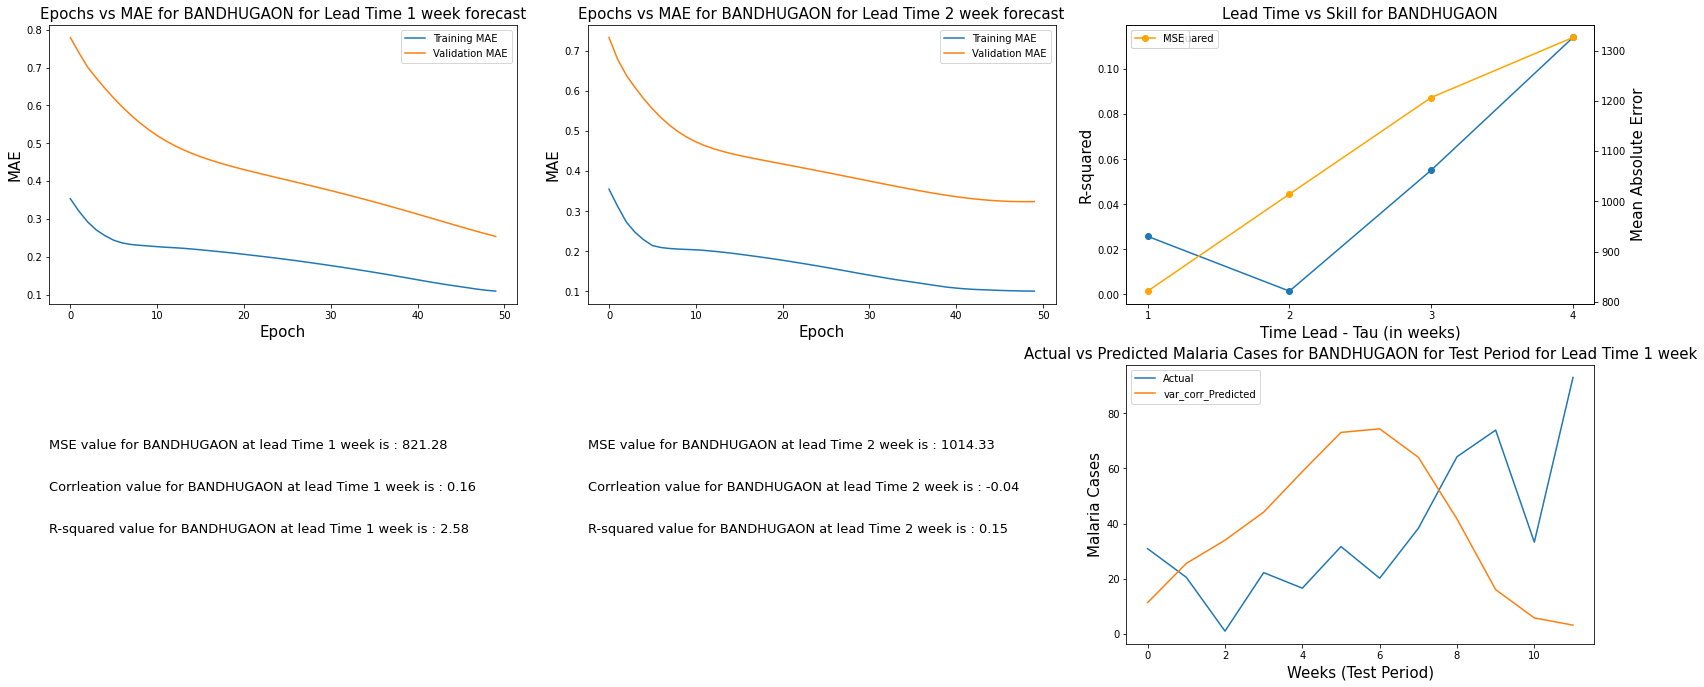

In [57]:
test = predictions('BANDHUGAON')
test.show_training_results()

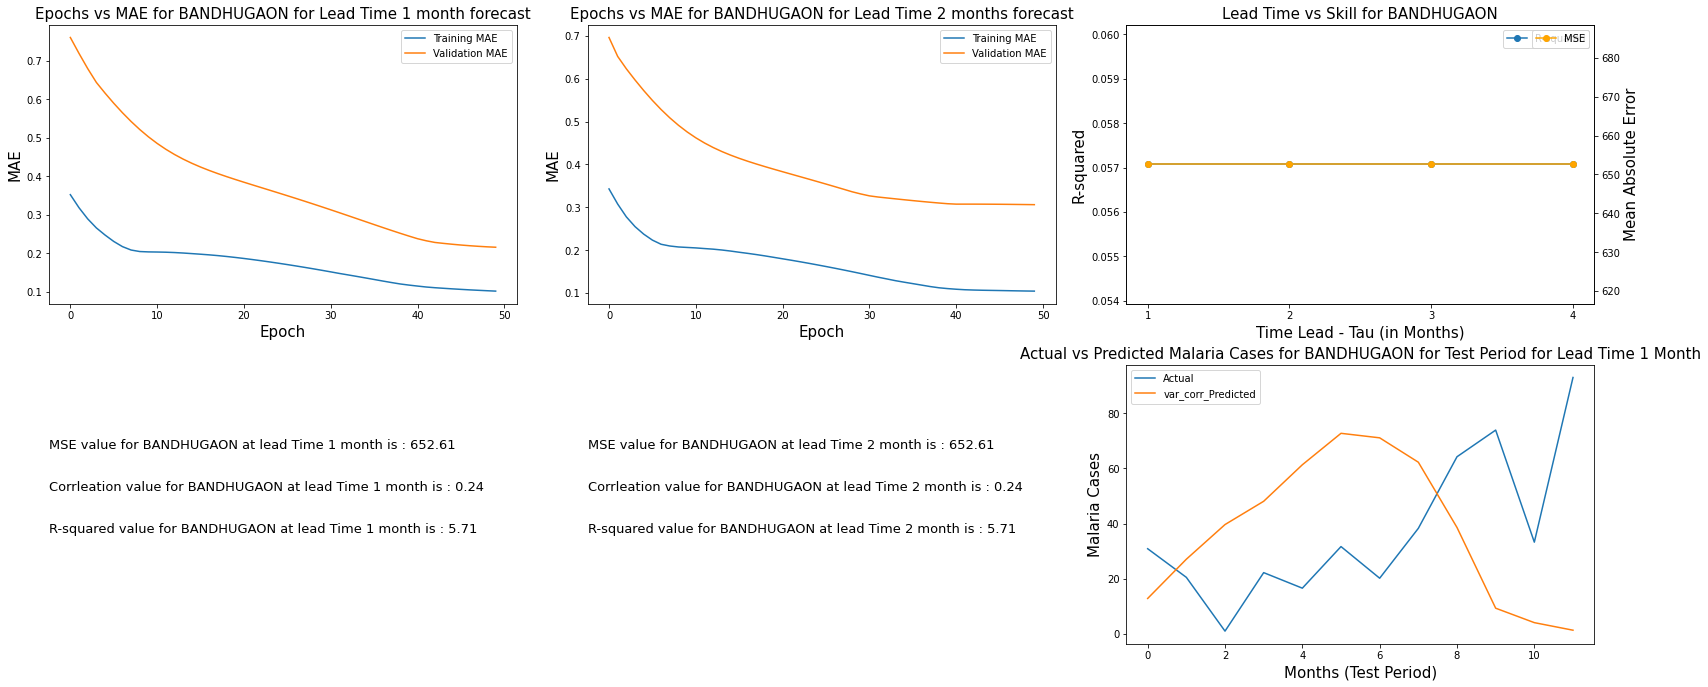

In [61]:
test = predictions('BANDHUGAON')
test.show_training_results()